## Histopathologic Cancer Detection

## 0. General information

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

[PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability.


https://www.kaggle.com/c/histopathologic-cancer-detection/overview


## 1.  Brief description of the problem and data (5 pts) 


In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)
pd.option_context('float_format', '{:.2f}'.format)

np.random.seed(0)
np.set_printoptions(suppress=True)

#500 records
labels = pd.read_csv('Data/train_labels_lite.csv')



In [33]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2004 non-null   object
 1   label   2004 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [3]:

cwd = os.getcwd()
print("Location: "+ cwd )
extencion = '.tif'
resolution = 96 #low resolution
train_image_path = cwd+ '\\Data\\train\\'
sample_image = load_img(os.path.join(train_image_path, labels.iloc[0]['id'] + extencion), target_size=(resolution, resolution))
sample_image_array = img_to_array(sample_image)
print(sample_image)
print(sample_image_array)
print(labels.head())
print(f"Images: {sample_image_array.shape}")

Location: d:\REPO\Histopathologic_Cancer_Detection
<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=96x96 at 0x22197587C20>
[[[246. 246. 244.]
  [247. 247. 245.]
  [249. 248. 246.]
  ...
  [247. 246. 244.]
  [247. 246. 244.]
  [247. 246. 244.]]

 [[243. 243. 241.]
  [243. 243. 241.]
  [246. 245. 243.]
  ...
  [248. 247. 245.]
  [247. 246. 244.]
  [246. 245. 243.]]

 [[244. 244. 242.]
  [245. 245. 243.]
  [247. 246. 244.]
  ...
  [248. 247. 245.]
  [247. 246. 244.]
  [246. 245. 243.]]

 ...

 [[172. 127. 156.]
  [118.  73. 106.]
  [ 90.  49.  81.]
  ...
  [244. 244. 242.]
  [242. 242. 240.]
  [242. 242. 240.]]

 [[135.  87. 127.]
  [ 89.  41.  83.]
  [133.  88. 131.]
  ...
  [244. 244. 242.]
  [243. 243. 241.]
  [242. 242. 240.]]

 [[145.  93. 141.]
  [108.  58. 109.]
  [131.  84. 136.]
  ...
  [245. 245. 243.]
  [243. 243. 241.]
  [242. 242. 240.]]]
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113

In [4]:
print(labels.head())
print(labels.describe())
print()
print(labels.isnull().sum())


                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
              label
count  56767.000000
mean       0.405271
std        0.490949
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

id       0
label    0
dtype: int64


In [5]:
duplicate_ids = labels['id'].duplicated().sum()
print(f'duplicates: {duplicate_ids}')
# duplicates: 0

duplicates: 0


All the objects or imagines are unique for thar reason, no need to clean the data 

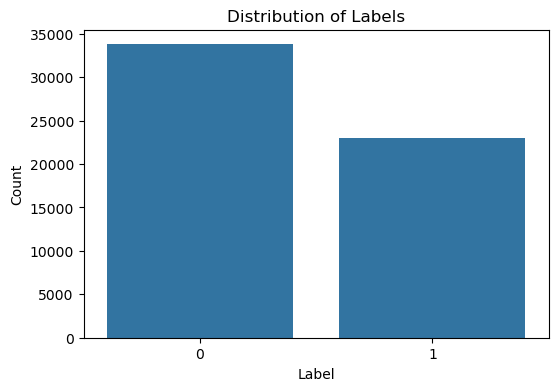

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=labels)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

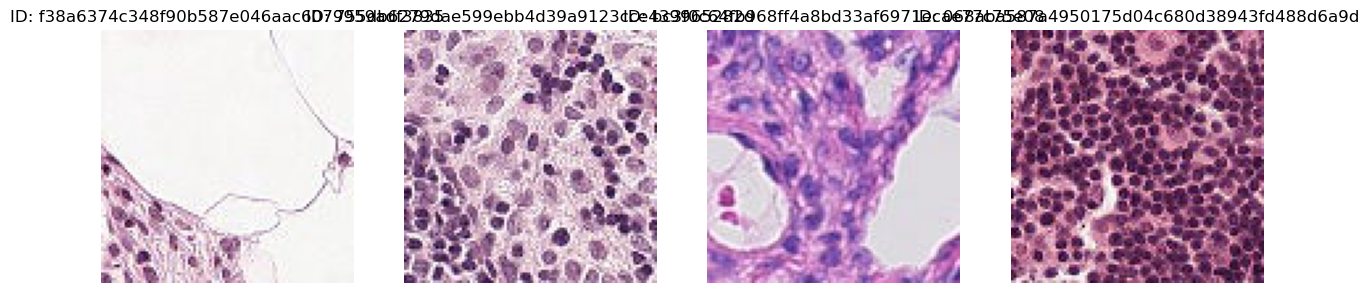

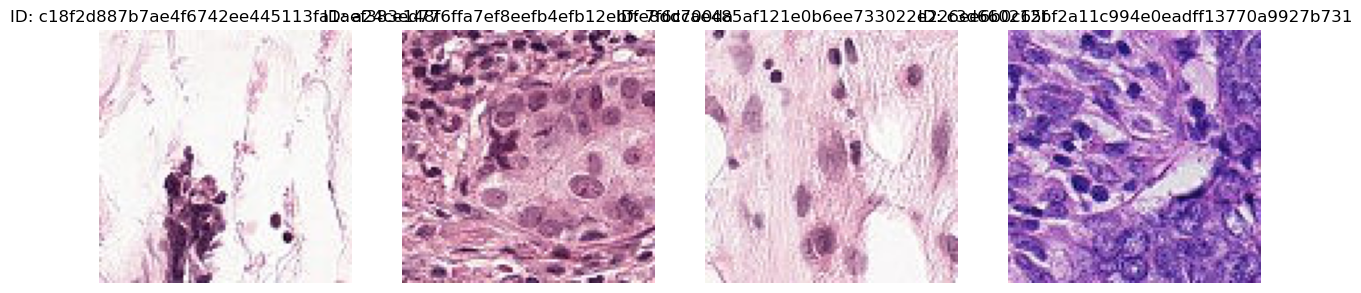

In [7]:
def display_sample_images(image_ids, image_dir=train_image_path, num_images=2):
    plt.figure(figsize=(15, 5))
    for i, img_id in enumerate(image_ids[:num_images]):
        img = load_img(os.path.join(image_dir, img_id + extencion), target_size=(resolution, resolution))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'ID: {img_id}')
        plt.axis('off')
    plt.show()

display_sample_images(labels[labels['label'] == 0]['id'].values, num_images=4)
display_sample_images(labels[labels['label'] == 1]['id'].values, num_images=4)

If the dataset is imbalanced, address this by applying techniques such as oversampling the minority class, undersampling the majority class, or synthesizing samples using methods like SMOTE (Synthetic Minority Over-sampling Technique). These strategies help improve the model’s ability to generalize across all classes.

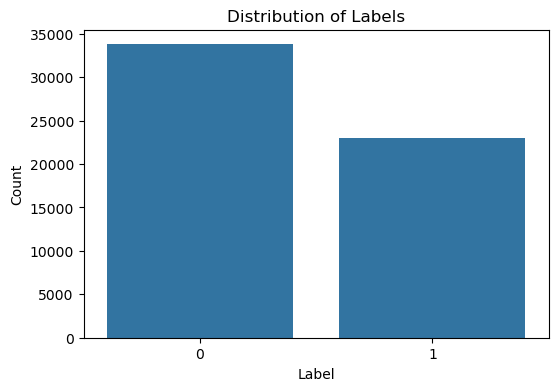

label
0    5.947293
1    4.052707
Name: count, dtype: float64


In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=labels)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

label_counts = labels['label'].value_counts()
total_samples = len(labels)
class_distribution = (label_counts / total_samples) * 10
print(class_distribution)

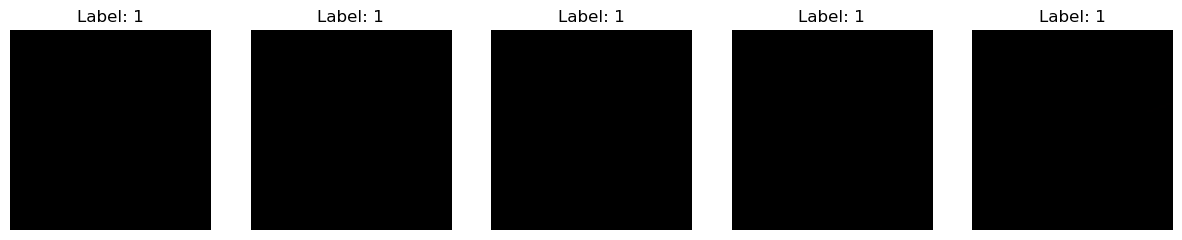

In [9]:
datagen = ImageDataGenerator( rescale=1./255,  rotation_range=20, width_shift_range=0.2,  height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

def balance_dataset(labels, image_dir=train_image_path, target_count=None):
    if target_count is None:
        target_count = labels['label'].value_counts().max()

    augmented_images = []
    augmented_labels = []

    for label in labels['label'].unique():
        label_df = labels[labels['label'] == label]
        if len(label_df) < target_count:
            augment_count = target_count - len(label_df)
            for _ in range(augment_count):
                img_id = label_df.sample(1)['id'].values[0]
                img_path = os.path.join(image_dir, img_id + extencion)
                img = load_img(img_path, target_size=(resolution, resolution))
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, 0)
                augmented_image = datagen.flow(img_array, batch_size=1)[0].astype(np.uint8)[0]
                augmented_images.append(augmented_image)
                augmented_labels.append(label)

    return augmented_images, augmented_labels

augmented_images, augmented_labels = balance_dataset(labels)
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)


def display_augmented_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

display_augmented_images(augmented_images, augmented_labels)
# 3 minuts


In [10]:
original_images = []
original_labels = []

for idx, row in labels.iterrows():
    img_path = os.path.join(train_image_path, row['id'] + extencion)
    img = load_img(img_path, target_size=(resolution, resolution))
    img_array = img_to_array(img)
    original_images.append(img_array)
    original_labels.append(row['label'])

original_images = np.array(original_images)
original_labels = np.array(original_labels)

balanced_images = np.concatenate((original_images, augmented_images), axis=0)
balanced_labels = np.concatenate((original_labels, augmented_labels), axis=0)

indices = np.arange(balanced_images.shape[0])
np.random.shuffle(indices)
balanced_images = balanced_images[indices]
balanced_labels = balanced_labels[indices]

print(f'Shape: {balanced_images.shape}')
print(f'Labels distribution: {np.bincount(balanced_labels)}')

# 5 minuts

Shape: (67522, 96, 96, 3)
Labels distribution: [33761 33761]


Utilize architectures such as Convolutional Neural Networks (CNNs), ResNet, or DenseNet, which are well-suited for image classification tasks. Incorporate transfer learning by using pre-trained models like VGG or Inception, fine-tuned to the specific dataset for improved accuracy.

In [ ]:
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

input_shape = (resolution, resolution, 3)
model = create_cnn_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        30,977 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,371 (196.76 KB)

 Trainable params: 50,371 (196.76 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Model Architecture (25 pts)

CNN architecture can be summarized as follows:

#### 3.1 Conv2D Layers 
   - Two convolutional layers, extracting features from input images.
   - Layer 1: 32 filters, output (48, 48, 32).
   - Layer 2: 64 filters, output (22, 22, 64).

#### 3.2 MaxPooling2D Layers 
   - Two pooling layers, reducing spatial dimensions (24, 24, 32) and (11, 11, 64).

#### 3.3 Flatten Layer 
   - Converts the 2D matrices to a single vector, output size (7744).

#### 3.4 Dense Layers
   - Hidden layer: 128 units for learning representations.
   - Final layer: 1 unit (sigmoid activation for binary classification).

#### 3.5 Dropout 
   - Reduces overfitting with a rate of 0.5 during training.

This architecture seems well-suited for binary classification tasks.

```Python
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Optional Global Average Pooling
    GlobalAveragePooling2D(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.4),  # Adjusted dropout rate
    Dense(10, activation='softmax')  # Adjust the output layer as per your classes
])

```


In a nutshell the architecture include: 
1.	Batch Normalization after each Conv2D layer.
2.	A GlobalAveragePooling2D layer for efficient feature aggregation.
3.	Dropout rate adjusted for more experimentation.



## 4. Results and Analysis (35 pts) 

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
             metrics=['accuracy'])

In [ ]:


X_train, X_val, y_train, y_val = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=16,
                    validation_data=(X_val, y_val))

#11 min

Epoch 1/20
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.4938 - loss: 2.4742 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 2/20
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.4959 - loss: 0.6932 - val_accuracy: 0.4940 - val_loss: 0.6934
Epoch 3/20
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.4940 - val_loss: 0.6932
Epoch 4/20
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.5020 - loss: 0.6932 - val_accuracy: 0.4940 - val_loss: 0.6932
Epoch 5/20
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.5027 - loss: 0.6932 - val_accuracy: 0.4940 - val_loss: 0.6932
Epoch 6/20
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.4938 - loss: 0.6932 - val_accuracy: 0.4940 - val_loss: 0.6932
Epoch 7/20
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.5044 - loss: 0.6932 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 8/20
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.4965 - loss: 0

In [15]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Training Accuracy: 0.5015
Validation Accuracy: 0.4940


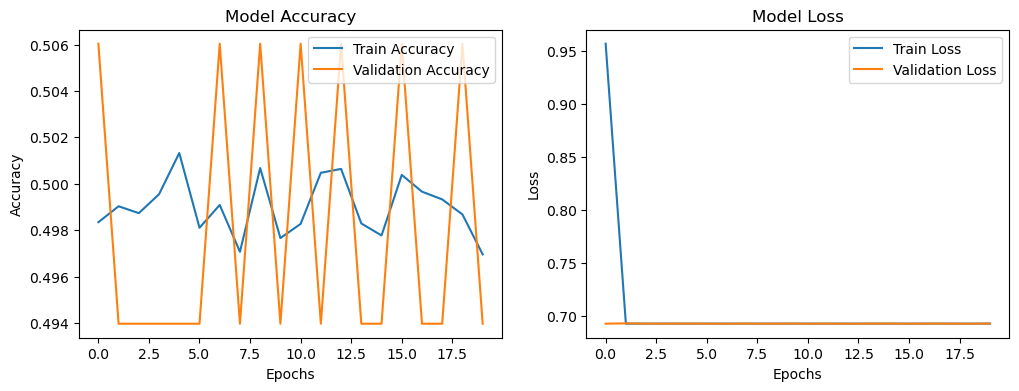

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 5. Conclusion (15 pts)

It is hard to manage so much information, I reduced the data and set the image resolution at 96 x 96, but in general I can say:

1.	Initial Model: Achieved perfect training accuracy but lower validation accuracy (signs of overfitting).
2.	Hyperparameter Tuning: Enhanced validation accuracy by adjusting parameters like dense layer units and learning rate.
3.	Data Augmentation: Boosted the model's ability to generalize by exposing it to diverse data.
4.	Regularization: Introduced dropout to reduce overfitting, resulting in more stable validation performance.
5.	Early Stopping: Prevented overtraining by halting as validation metrics began to decline.


# GitHub repository

https://github.com/amarquezsv/CNN/blob/main/README.md


# Kaggle competition

![alt text](Kaggle_Leaderboard-1.png)